# Regularization - Equal Thickness Lenses

In this example, we design a two lens system where the first lens is plano-convex, and the second lens is biconvex symmetric. Two parameters are used to describe the curvature of each lens.

This problem has many solutions because different shape combinations can achieve the desired focal length. Using regularization, we add the additional constraint that the inner thickness of each lens should be equal. This leads to a unique solution.

[('shape_convex_a', Parameter containing:
tensor(0.0050, requires_grad=True)), ('shape_biconvex_a', Parameter containing:
tensor(0.0050, requires_grad=True))]
rays aperture 0.0
rays aperture 0.8867159
rays aperture 0.0
rays aperture 0.8457632
rays aperture 0.8283653


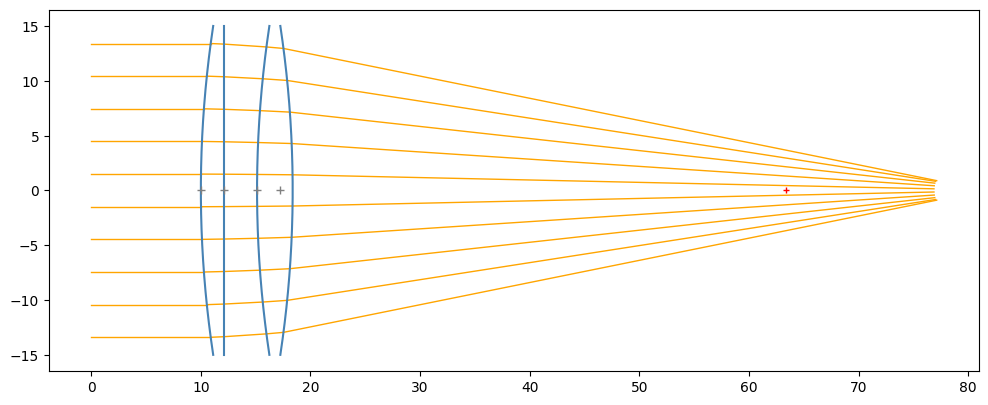

[  0/250] L= 132.160 | grad norm= 110642.1484375


[ 13/250] L=  6.532 | grad norm= 5033.79833984375


[ 26/250] L=  5.073 | grad norm= 15275.310546875


[ 39/250] L=  2.167 | grad norm= 10209.4482421875


[ 52/250] L=  0.238 | grad norm= 839.2432250976562


[ 65/250] L=  0.115 | grad norm= 3009.763427734375


[ 78/250] L=  0.012 | grad norm= 448.8642272949219


[ 91/250] L=  0.015 | grad norm= 556.3670043945312


[104/250] L=  0.012 | grad norm= 419.8523864746094


[117/250] L=  0.010 | grad norm= 166.763916015625


[130/250] L=  0.010 | grad norm= 40.875736236572266


[143/250] L=  0.010 | grad norm= 4.8666887283325195


[156/250] L=  0.010 | grad norm= 5.430457592010498


[169/250] L=  0.010 | grad norm= 2.6166961193084717


[182/250] L=  0.010 | grad norm= 0.3275591731071472


[195/250] L=  0.010 | grad norm= 0.8963059782981873


[208/250] L=  0.010 | grad norm= 1.0084797143936157


[221/250] L=  0.010 | grad norm= 0.8018078207969666


[234/250] L=  0.010 | grad norm= 0.47481730580329895


[247/250] L=  0.010 | grad norm= 0.25133806467056274


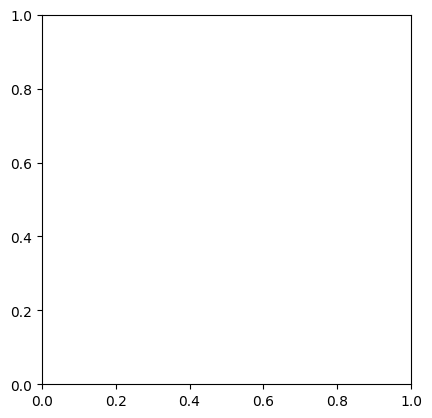

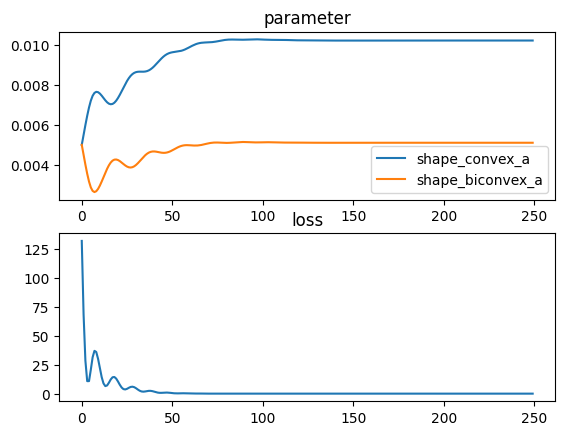

rays aperture 0.0
rays aperture 1.810935
rays aperture 0.0
rays aperture 0.81921005
rays aperture 0.7910042


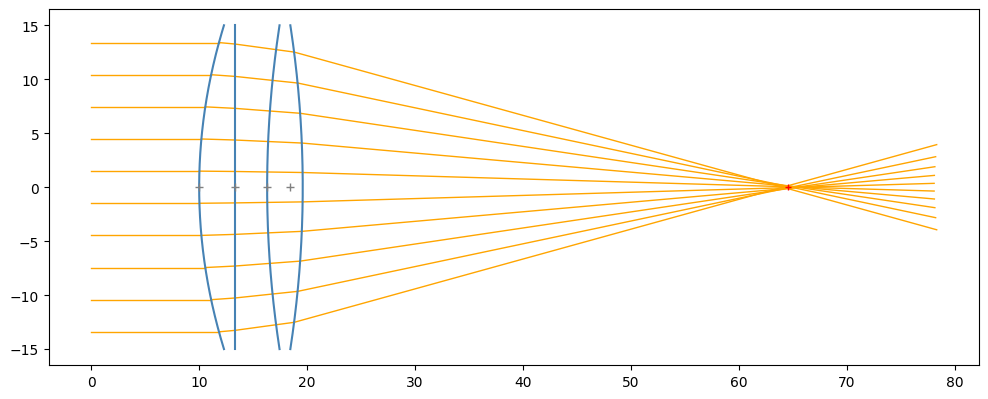

Plano-convex inner thickness 3.2976
Bi-convex inner thickness 3.2975


In [1]:
import math
import torch
import torch.nn as nn
import numpy as np

import torch.optim as optim
import torchlensmaker as tlm


class Optics(tlm.Module):
    def __init__(self):
        super().__init__()

        lens_radius = 30
        focal_length = 45
        lens_outer_thickness = 1.0
        material = (1.0, 1.5) # air and glass

        # Shape of the curved surface of the plano convex lens
        self.shape_convex = tlm.Parabola(lens_radius, nn.Parameter(torch.tensor(0.005)))

        # Shape of the two curved surfaces of the biconvex symmetric lens
        self.shape_biconvex = tlm.Parabola(lens_radius, nn.Parameter(torch.tensor(0.005)))
    
        self.plano = tlm.PlanoLens(
            self.shape_convex,
            n = material,
            outer_thickness = lens_outer_thickness,
        )
        
        self.biconvex = tlm.SymmetricLens(
            self.shape_biconvex,
            n = material,
            outer_thickness = lens_outer_thickness,
        )

        self.optics = tlm.OpticalSequence(
            tlm.PointSourceAtInfinity(0.9*lens_radius),
            tlm.Gap(10.),
            self.plano,
            tlm.Gap(3.),
            self.biconvex,
            tlm.Gap(focal_length),
            tlm.FocalPoint(),
        )

    def forward(self, inputs, sampling):
        return self.optics(inputs, sampling)


def regu_equalthickness(optics):
    t0 = optics.plano.inner_thickness()
    t1 = optics.biconvex.inner_thickness()
    return 100*torch.pow(t0 - t1, 2)


optics = Optics()

print(list(optics.named_parameters()))

tlm.render_plt(optics, force_uniform_source=False)

tlm.optimize(
    optics,
    optimizer = optim.Adam(optics.parameters(), lr=5e-4),
    sampling = {"rays": 10},
    num_iter = 250,
    regularization = regu_equalthickness,
)

tlm.render_plt(optics, force_uniform_source=False)

print(f"Plano-convex inner thickness {optics.plano.inner_thickness():.4f}")
print(f"Bi-convex inner thickness {optics.biconvex.inner_thickness():.4f}")

In [2]:
from IPython.display import display

display(tlm.lens_to_part(optics.plano))
display(tlm.lens_to_part(optics.biconvex))

Part at 0x784361adac00, label(), #children(0)

Part at 0x784361913290, label(), #children(0)